# Type 1 transition 

In [16]:
import pandas as pd
import numpy as np
import json
import matplotlib.pylab as plt
%matplotlib inline

from tyssue import Sheet, Monolayer, config
from tyssue import SheetGeometry, PlanarGeometry


# What we're here for
from tyssue.topology.sheet_topology import type1_transition
from tyssue.topology.base_topology import collapse_edge, remove_face
from tyssue.topology.sheet_topology import split_vert as sheet_split
from tyssue.topology.bulk_topology import split_vert as bulk_split
from tyssue.topology import condition_4i, condition_4ii

## model and solver
from tyssue.dynamics.sheet_vertex_model import SheetModel as model
from tyssue.solvers.quasistatic import QSSolver
from tyssue.generation import extrude
from tyssue.dynamics import model_factory, effectors

# 2D plotting
from tyssue.draw import sheet_view, highlight_cells

#I/O
from tyssue.io import hdf5
plt.style.use('bmh')

import logging
geom = SheetGeometry

![Type 1 transition](illus/t1_transition.png)

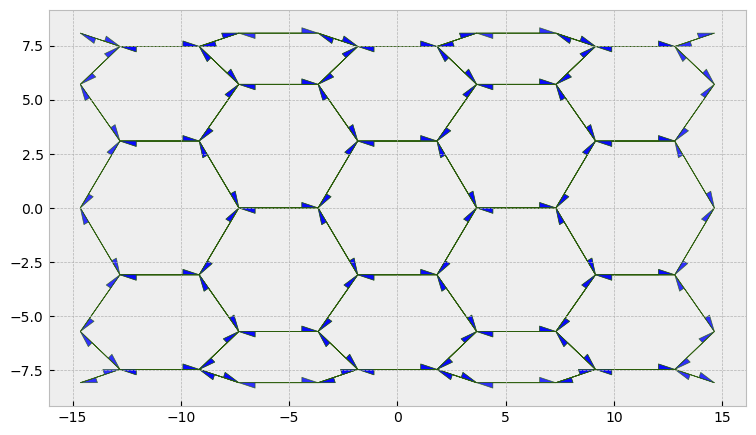

In [17]:
solver = QSSolver()

h5store = 'data/small_hexagonal.hf5'
datasets = hdf5.load_datasets(h5store,
                              data_names=['face', 'vert', 'edge'])
specs = config.geometry.cylindrical_sheet()
sheet = Sheet('emin', datasets, specs)


geom.update_all(sheet)

nondim_specs = config.dynamics.quasistatic_sheet_spec()
dim_model_specs = model.dimensionalize(nondim_specs)
sheet.update_specs(dim_model_specs, reset=True)

solver_settings = {'options': {'gtol':1e-4}}

sheet.get_opposite()
sheet.vert_df.is_active = 0

active_edges = (sheet.edge_df['opposite'] > -1)
active_verts = np.unique(sheet.edge_df[active_edges]['srce'])

sheet.vert_df.loc[active_verts, 'is_active'] = 1

fig, ax = sheet_view(sheet, ['z', 'x'],
                     edge={'head_width': 0.5},
                     vert={'visible': False})
fig.set_size_inches(10, 6)


In [18]:
type1_transition(sheet, 82)
geom.update_all(sheet)


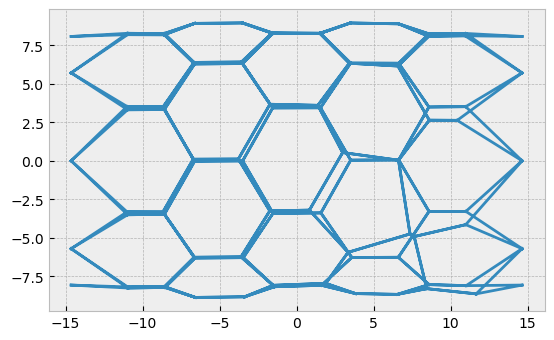

In [19]:
res = solver.find_energy_min(sheet, geom, model, **solver_settings)
fig, ax = sheet_view(sheet, mode="quick", coords=['z', 'x'])


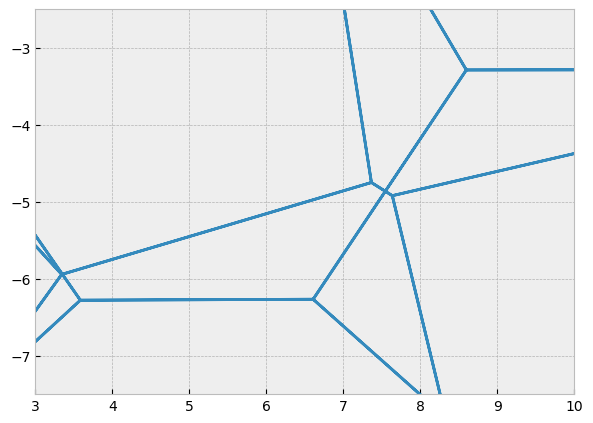

In [20]:

fig, ax = sheet_view(sheet, ['z', 'x'], mode="quick")

ax.set_xlim(3, 10)
ax.set_ylim(-7.5, -2.5)

ax.set_aspect('equal')
fig.set_size_inches(8, 5)


In [21]:
fig, mesh = sheet_view(sheet, mode='3D')
fig

Figure(camera=PerspectiveCamera(aspect=0.8, fov=45.0, matrixWorldNeedsUpdate=True, position=(-1.26184024505868…

True


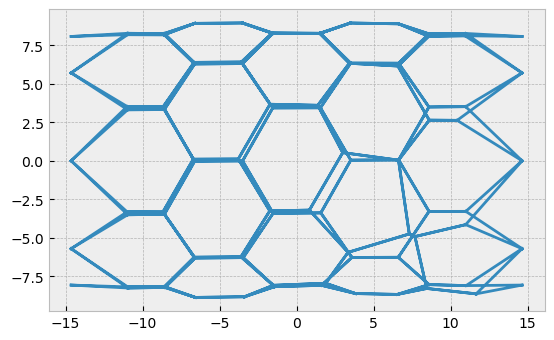

In [22]:
res = solver.find_energy_min(sheet, geom, model)
print(res['success'])
fig, ax = sheet_view(sheet, ['z', 'x'], mode="quick")


In [23]:
sheet.validate()

True

#### Type 1 transitions can also be performed on border faces

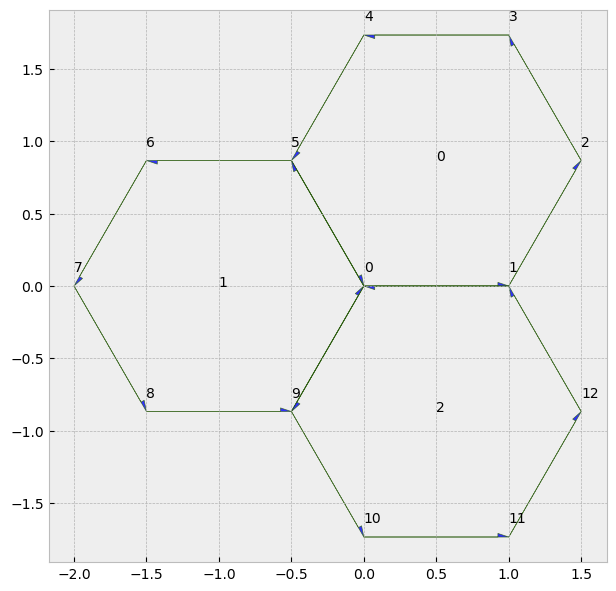

In [24]:
from tyssue.generation import three_faces_sheet

sheet = Sheet('3f', *three_faces_sheet())
geom.update_all(sheet)
fig, ax = sheet_view(sheet, edge={'head_width': 0.05})
fig.set_size_inches(8, 8)

for face, data in sheet.face_df.iterrows():
    ax.text(data.x, data.y, face)
for vert, data in sheet.vert_df.iterrows():
    ax.text(data.x, data.y+0.1, vert)



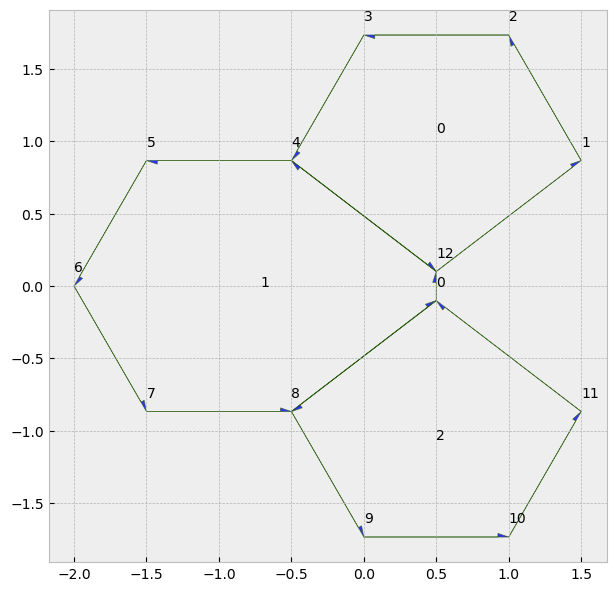

In [25]:

type1_transition(sheet, 0, multiplier=2)
sheet.reset_index()

geom.update_all(sheet)

fig, ax = sheet_view(sheet, edge={'head_width': 0.05})
fig.set_size_inches(8, 8)
for face, data in sheet.face_df.iterrows():
    ax.text(data.x, data.y, face)

for vert, data in sheet.vert_df.iterrows():
    ax.text(data.x, data.y+0.1, vert)

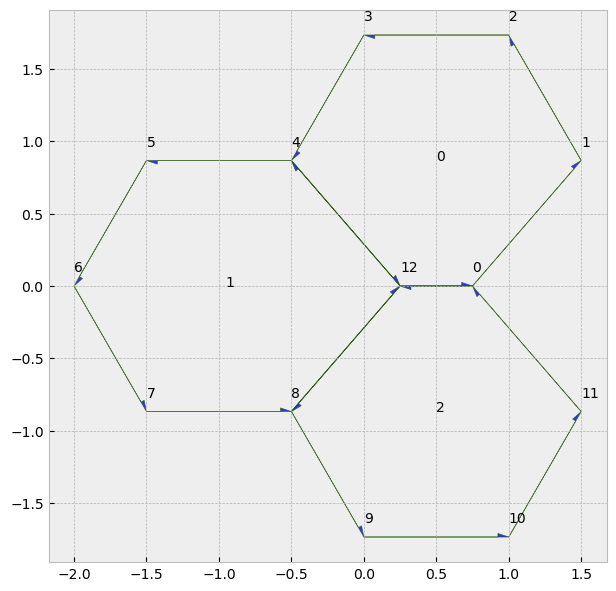

In [26]:
type1_transition(sheet, 16, multiplier=5)

geom.update_all(sheet)

fig, ax = sheet_view(sheet, edge={'head_width': 0.05})
fig.set_size_inches(8, 8)
for face, data in sheet.face_df.iterrows():
    ax.text(data.x, data.y, face)

for vert, data in sheet.vert_df.iterrows():
    ax.text(data.x, data.y+0.1, vert)

In [27]:
sheet.validate()

True

True


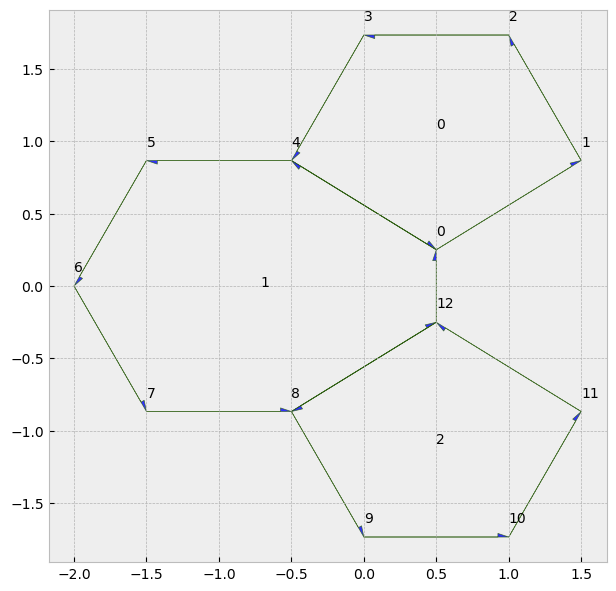

In [28]:
type1_transition(sheet, 17,  multiplier=5)

geom.update_all(sheet)
print(sheet.validate())

fig, ax = sheet_view(sheet, edge={'head_width': 0.05})
fig.set_size_inches(8, 8)
for face, data in sheet.face_df.iterrows():
    ax.text(data.x, data.y, face)

for vert, data in sheet.vert_df.iterrows():
    ax.text(data.x, data.y+0.1, vert)

# Rosette

This part is based on the following paper:

>**The tricellular vertex-specific adhesion molecule Sidekick facilitates polarised cell intercalation during Drosophila axis extension** _Tara M Finegan, Nathan Hervieux, Alexander Nestor-Bergmann, Alexander G. Fletcher, Guy B Blanchard, Benedicte Sanson_ bioRxiv 704932; doi: https://doi.org/10.1101/704932 

In particular, the authors expose a nice way to account for rosettes and solve topology changes in a more generic and I think robust way than T1 transition. I think, it allows vertices with more than 3 out-edges to have a finite lifetime, and avoids T1 oscillations



I explore its implementation in [tyssue](https://github.com/damcb/tyssue), in 2D (also maybe in 3D, though it's less clear how :p).

### Create a small patch of cells in 2D and a simple mechanical model

In [29]:
sheet = Sheet.planar_sheet_2d('flat', 30, 30, 1, 1, noise=0.2)
geom = PlanarGeometry

to_cut = sheet.cut_out([(0.1, 6), (0.1, 6)])
sheet.remove(to_cut, trim_borders=True)
sheet.sanitize(trim_borders=True)
geom.center(sheet)
geom.update_all(sheet)
sheet.update_rank()
model = model_factory(
    [
        effectors.LineTension,
        effectors.FaceContractility,
        effectors.FaceAreaElasticity
    ]
)

specs = {
    "face": {
        "contractility": 5e-2,
        "prefered_area": sheet.face_df.area.mean(),
        "area_elasticity": 1.
    },
    "edge": {
        "line_tension": 1e-2,
        "is_active": 1
    },
    "vert": {
        "is_active": 1
    },
}

sheet.update_specs(specs, reset=True)

### Gradient descent

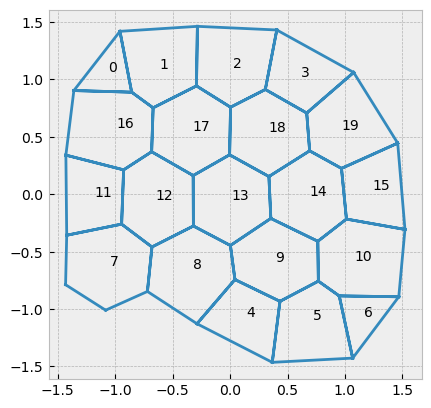

In [31]:
solver = QSSolver()

res = solver.find_energy_min(sheet, geom, model)

fig, ax = sheet_view(sheet, mode="quick")
for f, (x, y) in sheet.face_df[["x", "y"]].iterrows():
    ax.text(x, y, f)


In [43]:
%pdb

Automatic pdb calling has been turned ON


In [44]:


sheet = Sheet.planar_sheet_2d('flat', 30, 30, 1, 1, noise=0.)
geom = PlanarGeometry

to_cut = sheet.cut_out([(0.1, 6), (0.1, 6.)])
sheet.remove(to_cut, trim_borders=True)
sheet.sanitize(trim_borders=True)
geom.center(sheet)
geom.update_all(sheet)

#remove_face(sheet, 13)

fig, ax = sheet_view(sheet, mode="quick")
for f, (x, y) in sheet.face_df[["x", "y"]].iterrows():
    ax.text(x, y, f)



IndexError: index 70 is out of bounds for axis 0 with size 70

> /home/guillaume/mambaforge/envs/tyssue/lib/python3.10/site-packages/pandas/core/algorithms.py(1573)take()
   1571     else:
   1572         # NumPy style
-> 1573         result = arr.take(indices, axis=axis)
   1574     return result
   1575 



ipdb>  u


> /home/guillaume/mambaforge/envs/tyssue/lib/python3.10/site-packages/pandas/core/indexes/base.py(1184)take()
   1182         values = self._values
   1183         if isinstance(values, np.ndarray):
-> 1184             taken = algos.take(
   1185                 values, indices, allow_fill=allow_fill, fill_value=self._na_value
   1186             )



ipdb>  u


> /home/guillaume/mambaforge/envs/tyssue/lib/python3.10/site-packages/pandas/core/series.py(930)take()
    928 
    929         indices = ensure_platform_int(indices)
--> 930         new_index = self.index.take(indices)
    931         new_values = self._values.take(indices)
    932 



ipdb>  u


> /home/guillaume/mambaforge/envs/tyssue/lib/python3.10/site-packages/tyssue-0.9.0-py3.10-linux-x86_64.egg/tyssue/core/objects.py(324)_upcast()
    322 
    323         # Assumes a flat index
--> 324         upcast = df.take(idx, axis=0)
    325         try:
    326             upcast.index = self.edge_df.index



ipdb>  df


trgt
0     False
1     False
2     False
4     False
5     False
      ...  
66    False
67     True
68    False
69    False
70     True
Length: 70, dtype: bool


ipdb>  u


> /home/guillaume/mambaforge/envs/tyssue/lib/python3.10/site-packages/tyssue-0.9.0-py3.10-linux-x86_64.egg/tyssue/core/objects.py(389)upcast_trgt()
    387         if isinstance(df, str):
    388             df = self.vert_df[df]
--> 389         return self._upcast(self.edge_df["trgt"], df)
    390 
    391     def upcast_face(self, df):



ipdb>  u


> /home/guillaume/mambaforge/envs/tyssue/lib/python3.10/site-packages/tyssue-0.9.0-py3.10-linux-x86_64.egg/tyssue/topology/base_topology.py(380)merge_border_edges()
    378 
    379     single_trgt = sheet.edge_df[
--> 380         sheet.upcast_trgt(sheet.edge_df.groupby("trgt").apply(len) == 1)
    381     ]
    382     faces = set(single_trgt["face"])



ipdb>  c


In [50]:
connectiv = sheet.edge_df.groupby("trgt").apply(len) == 1

In [52]:
sheet.reset_index()

In [53]:
connectiv = sheet.edge_df.groupby("trgt").apply(len) == 1

In [59]:
set(sheet.edge_df.trgt) == set(sheet.vert_df.index)

False

In [60]:
sheet.validate()

False

In [63]:
bad_edges = sheet.edge_df[sheet.get_invalid()]

In [64]:
bad_edges

,trgt,nz,length,face,srce,dx,dy,sx,sy,tx,ty,fx,fy,ux,uy,is_valid
edge,,,,,,,,,,,,,,,,
6,0,1.0,1.0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
8,1,1.0,1.0,1,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
21,10,1.0,1.0,1,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
24,9,1.0,1.0,2,15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
30,13,1.0,1.0,3,16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
31,15,1.0,1.0,2,13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
43,47,1.0,1.0,4,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
45,16,1.0,1.0,3,47,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
50,4,1.0,1.0,5,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False


In [58]:
connectiv.index

Int64Index([ 0,  1,  2,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
            35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
            52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
            69, 70],
           dtype='int64', name='trgt')

In [54]:
sheet.upcast_trgt(connectiv)

IndexError: index 70 is out of bounds for axis 0 with size 70

> /home/guillaume/mambaforge/envs/tyssue/lib/python3.10/site-packages/pandas/core/algorithms.py(1573)take()
   1571     else:
   1572         # NumPy style
-> 1573         result = arr.take(indices, axis=axis)
   1574     return result
   1575 



ipdb>  c


In [56]:
sheet.vert_df.index


RangeIndex(start=0, stop=71, step=1, name='vert')

In [57]:
sheet.vert_df

,y,is_active,x
vert,,,
0,0.625,1,0.5
1,0.375,1,1.0
2,0.375,1,5.0
3,0.375,1,6.0
4,0.625,1,5.5
...,...,...,...
66,3.375,1,5.5
67,3.625,1,6.0
68,4.625,1,2.5


## Formation of rosettes

<hr/>

![first screencap, forming rosettes](illus/finegan_etal_screencap1.png)

_Finegan et al. 2019_

### Merge vertices

Or, said otherwise, collapse an edge

Maximum vertex rank:  4


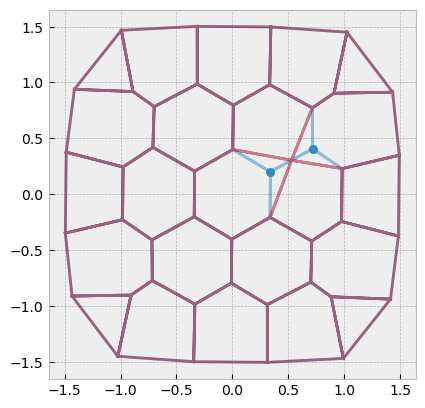

In [17]:
fig, ax = sheet_view(sheet, mode="quick", edge={"alpha": 0.5})
center_edge = sheet.edge_df.eval("sx**2 + sy**2").idxmin()
ax.scatter(sheet.edge_df.loc[center_edge, ["sx", "tx"]],
           sheet.edge_df.loc[center_edge, ["sy", "ty"]])

collapse_edge(sheet, center_edge)
sheet.update_rank()

geom.update_all(sheet)
fig, ax = sheet_view(sheet, mode="quick", ax=ax, edge={"alpha": 0.5})

print("Maximum vertex rank: ", sheet.vert_df['rank'].max())

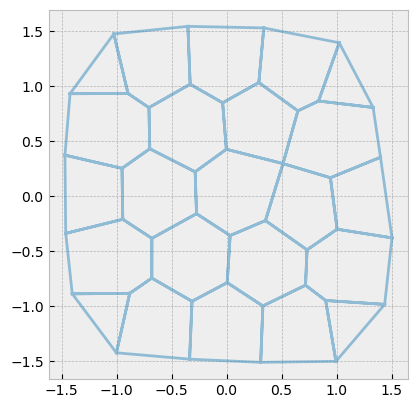

In [18]:
res = solver.find_energy_min(sheet, geom, model)
fig, ax = sheet_view(sheet, mode="quick", edge={"alpha": 0.5})


### Do it again to increase rank

Maximum vertex rank:  5


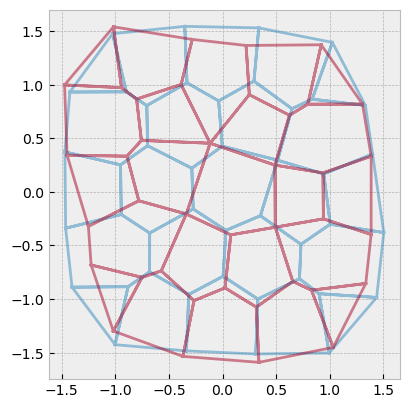

In [19]:
fig, ax = sheet_view(sheet, mode="quick", edge={"alpha": 0.5})

for i in range(4):
    center_edge = sheet.edge_df.eval("sx**2 + sy**2").idxmin()
    collapse_edge(sheet, center_edge)
    geom.update_all(sheet)
    res = solver.find_energy_min(sheet, geom, model)
    sheet.update_rank()

fig, ax = sheet_view(sheet, mode="quick", ax=ax, edge={"alpha": 0.5})


print("Maximum vertex rank: ", sheet.vert_df['rank'].max())

## Rosettes resolution

<hr/>

![Second screencap, solving rosettes](illus/finegan_etal_screencap2.png)

_Finegan et al. 2019_



As far as I understand, the difference between rank 5+ and rank 4 is not topological, but geometrical (the "old" vertex is moved towards the opposite cell center) and statistical because $p_4$ is higher than $p_{5+}$

### Solve for a single edge

Maximum vertex rank prior to rearangement:  5
Maximum vertex rank after rearangement:  4


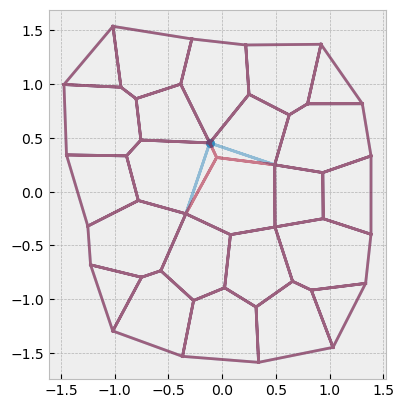

In [20]:
#sheet = bck.copy()
max_rank = sheet.vert_df['rank'].idxmax()

print("Maximum vertex rank prior to rearangement: ", sheet.vert_df['rank'].max())


fig, ax = sheet_view(sheet, mode="quick", edge={"alpha": 0.5})
max_rank_vert = sheet.vert_df['rank'].idxmax()

ax.scatter(sheet.vert_df.loc[max_rank_vert, "x"],
           sheet.vert_df.loc[max_rank_vert, "y"])

sheet_split(sheet, max_rank_vert)
sheet.update_rank()

geom.update_all(sheet)
fig, ax = sheet_view(sheet, mode="quick", ax=ax, edge={"alpha": 0.5})

print("Maximum vertex rank after rearangement: ", sheet.vert_df['rank'].max())


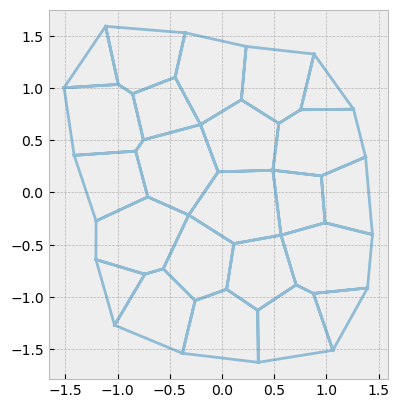

In [21]:
res = solver.find_energy_min(sheet, geom, model)
fig, ax = sheet_view(sheet, mode="quick", edge={"alpha": 0.5})

### Solve repeatedly

Maximum vertex rank prior to rearangement:  4
Maximum vertex rank:  4
Maximum vertex rank:  4
Maximum vertex rank:  4
Maximum vertex rank:  3


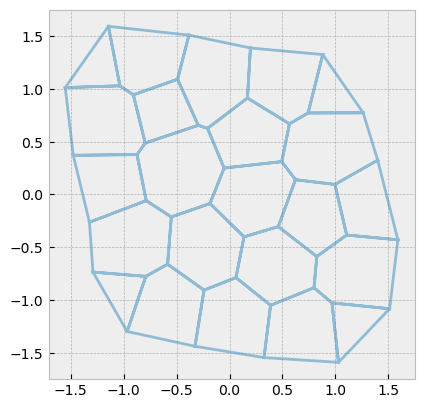

In [22]:
#sheet = bck.copy()
max_rank = sheet.vert_df['rank'].max()
print("Maximum vertex rank prior to rearangement: ", max_rank)

while max_rank > 3:
    max_rank_vert = sheet.vert_df['rank'].idxmax()

    sheet_split(sheet, max_rank_vert)
    sheet.update_rank()

    geom.update_all(sheet)

    res = solver.find_energy_min(sheet, geom, model)
    max_rank = sheet.vert_df['rank'].max()

    print("Maximum vertex rank: ", max_rank)

fig, ax = sheet_view(sheet, mode="quick", edge={"alpha": 0.5})

In [23]:
assert sheet.validate()

#### Collapse a face and resolve the rosette

In [24]:
remove_face(sheet, 12)
sheet.update_rank()
geom.update_all(sheet)

res = solver.find_energy_min(sheet, geom, model)

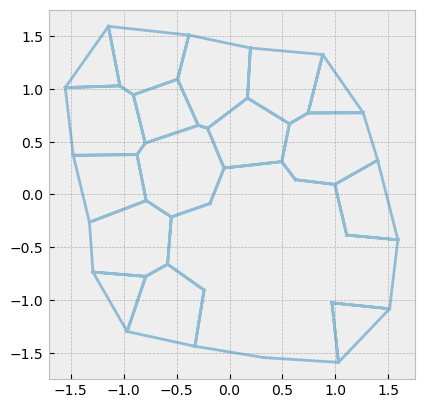

In [25]:
fig, ax = sheet_view(sheet, mode="quick", edge={"alpha": 0.5})


In [27]:
max_rank = sheet.vert_df['rank'].max()
while max_rank > 3:
    max_rank_vert = sheet.vert_df['rank'].idxmax()

    sheet_split(sheet, max_rank_vert)
    sheet.update_rank()

    geom.update_all(sheet)

    res = solver.find_energy_min(sheet, geom, model)
    max_rank = sheet.vert_df['rank'].max()

    print("Maximum vertex rank: ", max_rank)

Maximum vertex rank:  4
Maximum vertex rank:  3


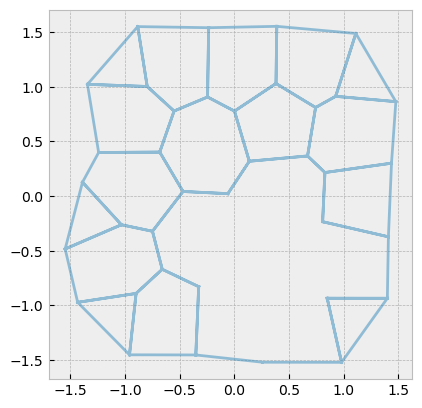

In [28]:
fig, ax = sheet_view(sheet, mode="quick", edge={"alpha": 0.5})

# How about in 3D?



### Illustration of the split / collapse algorithm in 3D


![illustration of the rearangements](illus/IH_transition.png)

### Extrude a monolayer from the previous sheet

In [29]:
from tyssue import MonolayerGeometry as geom

# Promote the sheet to 2.5 D
sheet.update_specs(config.geometry.sheet_spec())


specs = config.geometry.bulk_spec()
datasets = extrude(sheet.datasets, method='translation')
eptm = Monolayer('mono', datasets, specs)

geom.center(eptm)
geom.update_all(eptm) 

## Sanity check
assert eptm.validate()

/home/guillaume/mambaforge/envs/tyssue/lib/python3.10/site-packages/tyssue-0.9.0-py3.10-linux-x86_64.egg/tyssue/geometry/bulk_geometry.py:107: RuntimeWarning: invalid value encountered in divide
  weighted_pos.values / eptm.face_df["perimeter"].values[:, np.newaxis]


### Setup a simple mechanical model and quasistatically descend it

In [30]:
model = model_factory([
    effectors.CellVolumeElasticity,
    effectors.FaceContractility,
    effectors.LineTension,
])

## Initial model settings
dyn_specs = {
    "settings": {
        "threshold_length": 1e-3,
    },
    "cell": {
        "prefered_vol": eptm.cell_df.vol.mean(),
        "prefered_area": eptm.cell_df.area.mean(),
        "vol_elasticity": 14.0,
        #"area_elasticity": 1.0,
    },
    "face": {
        #"surface_tension": 1.0,
        "contractility": 1e-2
    },
    "edge": {
        "line_tension": 0.01,
    }
}

## Those settings are set homogenously in the epithelium
eptm.update_specs(dyn_specs, reset=True)

# Lower the lateral contractility
eptm.face_df.loc[eptm.lateral_faces, 'contractility'] /= 2

solver = QSSolver(with_t1=False, with_t3=False)
res = solver.find_energy_min(eptm, geom, model)
eptm.update_rank()

ipv.clear()
eptm.face_df["visible"] =True
fig, mesh = sheet_view(
    eptm,
    mode='3D',
    face={
        "visible": True,
        "color": eptm.face_df.area
    }
)

ipv.show()

/home/guillaume/mambaforge/envs/tyssue/lib/python3.10/site-packages/tyssue-0.9.0-py3.10-linux-x86_64.egg/tyssue/geometry/bulk_geometry.py:107: RuntimeWarning: invalid value encountered in divide
  weighted_pos.values / eptm.face_df["perimeter"].values[:, np.newaxis]
/home/guillaume/mambaforge/envs/tyssue/lib/python3.10/site-packages/tyssue-0.9.0-py3.10-linux-x86_64.egg/tyssue/geometry/bulk_geometry.py:107: RuntimeWarning: invalid value encountered in divide
  weighted_pos.values / eptm.face_df["perimeter"].values[:, np.newaxis]
/home/guillaume/mambaforge/envs/tyssue/lib/python3.10/site-packages/tyssue-0.9.0-py3.10-linux-x86_64.egg/tyssue/geometry/bulk_geometry.py:107: RuntimeWarning: invalid value encountered in divide
  weighted_pos.values / eptm.face_df["perimeter"].values[:, np.newaxis]
/home/guillaume/mambaforge/envs/tyssue/lib/python3.10/site-packages/tyssue-0.9.0-py3.10-linux-x86_64.egg/tyssue/geometry/bulk_geometry.py:107: RuntimeWarning: invalid value encountered in divide
  we

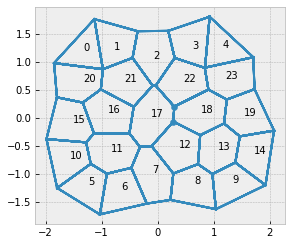

In [41]:
center_edge = eptm.edge_df.query('segment == "apical"').eval("sx**2 + sy**2").idxmin()

fig, ax = sheet_view(eptm, coords = ['x', 'y'], mode="quick")
for cell, (x, y) in eptm.cell_df[['x', 'y']].iterrows():
    ax.text(x, y, str(cell))
_= ax.scatter(
    eptm.edge_df.loc[center_edge, ['sx', 'tx']],
    eptm.edge_df.loc[center_edge, ['sy', 'ty']])


In [42]:
ret_code = collapse_edge(eptm, center_edge, allow_two_sided=True)
if ret_code:
    print('Collapse failed')
geom.update_all(eptm)

eptm.update_rank()
print("Maximum vertex rank: ", eptm.vert_df['rank'].max())

ipv.clear()
eptm.face_df["visible"] = eptm.face_df['segment'] == "lateral"
fig, mesh = sheet_view(
    eptm,
    mode='3D',
    face={
        "visible": True,
        "color": eptm.face_df.area
    }
)

ipv.show()

assert eptm.validate()


print("Maximum vertex rank: ", eptm.vert_df['rank'].max())
vert = eptm.vert_df['rank'].idxmax()
print("Rosette index: ", vert)
bck = eptm.copy()


Maximum vertex rank:  6


Maximum vertex rank:  6
Rosette index:  31


In [43]:
set(condition_4ii(eptm).ravel())

set()

In [44]:
res = solver.find_energy_min(eptm, geom, model)


In [45]:

eptm.settings['threshold_length'] = 0.1
bulk_split(eptm, vert, face=None, multiplier=2)

assert eptm.validate()

cell 18 is already closed
cell 22 is already closed
cell 17 is already closed
cell 12 is already closed


In [46]:
ipv.clear()
geom.update_all(eptm)
res = solver.find_energy_min(eptm, geom, model)

eptm.face_df["visible"] = False
#eptm.face_df["visible"] = eptm.face_df["segment"] == "lateral"
#eptm.face_df["visible"] = eptm.face_df.eval('(x**2 + (y+0.5)**2) < 0.5')
#eptm.face_df["visible"] = False
c4ii = np.unique(condition_4ii(eptm))
eptm.face_df.loc[c4ii, "visible"] = True
fig, mesh = sheet_view(
    eptm,
    mode='3D',
    face={
        "visible": True,
        "color": eptm.face_df.area
    }
)

ipv.show()

/home/admin-suz/miniconda3/lib/python3.8/site-packages/tyssue-0.8.1-py3.8-linux-x86_64.egg/tyssue/utils/utils.py:161: UserWarning: Sub epithelium appears to be empty
  warnings.warn("Sub epithelium appears to be empty")


## Testing vertex split towards all possible faces

In [47]:
all_edges = bck.edge_df[
    (bck.edge_df["trgt"] == vert)
    | (bck.edge_df["srce"] == vert)
]


eptms = {}
for face, edge in all_edges.reset_index().groupby("face").first()['edge'].items():
    eptm = bck.copy()
    cell = eptm.edge_df.loc[edge, "cell"]
    print(f"splitting vertex {vert} towards cell {cell} over face {face}")
    bulk_split(eptm, vert, face=face, multiplier=2)
    assert eptm.validate()
    c4i, c4ii = condition_4i(eptm), condition_4ii(eptm)
    if len(c4i):
        print(f"\nIssue with face {face}")
        print("Number of condition 4i faces : ", len(c4i))
    if len(c4ii):
        print(f"\nIssue with face {face}")
        print("Number of condition 4ii faces : ", len(c4ii))
    
    eptms[face] = eptm


cell 18 is already closed
cell 22 is already closed
cell 17 is already closed
cell 12 is already closed


splitting vertex 31 towards cell 12 over face 12
splitting vertex 31 towards cell 17 over face 17


cell 18 is already closed
cell 17 is already closed
cell 18 is already closed


splitting vertex 31 towards cell 18 over face 18


cell 17 is already closed


splitting vertex 31 towards cell 22 over face 22


cell 18 is already closed
cell 22 is already closed
cell 17 is already closed
cell 12 is already closed
cell 18 is already closed
cell 22 is already closed
cell 17 is already closed
cell 12 is already closed


splitting vertex 31 towards cell 18 over face 107


cell 18 is already closed
cell 22 is already closed
cell 17 is already closed
cell 12 is already closed


splitting vertex 31 towards cell 22 over face 108


cell 18 is already closed


splitting vertex 31 towards cell 18 over face 111


cell 17 is already closed


splitting vertex 31 towards cell 17 over face 112


cell 18 is already closed
cell 17 is already closed
cell 18 is already closed
cell 22 is already closed
cell 17 is already closed
cell 12 is already closed


splitting vertex 31 towards cell 17 over face 117


cell 18 is already closed
cell 22 is already closed
cell 17 is already closed
cell 12 is already closed


splitting vertex 31 towards cell 22 over face 118


cell 18 is already closed
cell 22 is already closed
cell 17 is already closed
cell 12 is already closed


splitting vertex 31 towards cell 12 over face 119


cell 18 is already closed
cell 22 is already closed
cell 17 is already closed
cell 12 is already closed


splitting vertex 31 towards cell 17 over face 120


cell 18 is already closed
cell 22 is already closed
cell 17 is already closed
cell 12 is already closed


splitting vertex 31 towards cell 12 over face 160


cell 18 is already closed
cell 22 is already closed
cell 17 is already closed
cell 12 is already closed


splitting vertex 31 towards cell 18 over face 161


In [48]:
ipv.clear()
geom.update_all(eptm)

eptm.face_df["visible"] = False
#eptm.face_df["visible"] = eptm.face_df["segment"] == "lateral"
#eptm.face_df["visible"] = eptm.face_df.eval('(x**2 + (y+0.5)**2) < 0.5')
#eptm.face_df["visible"] = False

eptm.face_df.loc[set(condition_4ii(eptm).ravel()[:2]), "visible"] = True
fig, mesh = sheet_view(
    eptm,
    mode='3D',
    face={
        "visible": True,
        "color": eptm.face_df.area
    }
)

ipv.show()

/home/admin-suz/miniconda3/lib/python3.8/site-packages/tyssue-0.8.1-py3.8-linux-x86_64.egg/tyssue/utils/utils.py:161: UserWarning: Sub epithelium appears to be empty
  warnings.warn("Sub epithelium appears to be empty")


### Collapsing a face

In [49]:
eptm.vert_df['rank'].min()

4

In [50]:
condition_4ii(eptm)

array([], shape=(0, 2), dtype=int64)

In [51]:
center_face = eptm.face_df.query("segment == 'apical'").eval("x**2 + y**2").idxmin()

remove_face(eptm, center_face)

0

In [52]:
ipv.clear()
geom.update_all(eptm)
res = solver.find_energy_min(eptm, geom, model)

#eptm.face_df["visible"] = False
eptm.face_df["visible"] = eptm.face_df["segment"] == "lateral"
#eptm.face_df["visible"] = eptm.face_df.eval('(x**2 + (y+0.5)**2) < 0.5')
#eptm.face_df["visible"] = False

#eptm.face_df.loc[set(condition_4ii(eptm).ravel()[:2]), "visible"] = True
fig, mesh = sheet_view(
    eptm,
    mode='3D',
    face={
        "visible": True,
        "color": eptm.face_df.area
    }
)

ipv.show()

### Split the created vertex

In [53]:
vert = eptm.vert_df.index[-1]

bulk_split(eptm, vert)


geom.update_all(eptm)

assert eptm.validate()

cell 2 is already closed
cell 7 is already closed
cell 12 is already closed
cell 18 is already closed
cell 11 is already closed
cell 16 is already closed
cell 17 is already closed


In [54]:
ipv.clear()
geom.update_all(eptm)
res = solver.find_energy_min(eptm, geom, model)

#eptm.face_df["visible"] = False
eptm.face_df["visible"] = eptm.face_df["segment"] == "lateral"
#eptm.face_df["visible"] = eptm.face_df.eval('(x**2 + (y+0.5)**2) < 0.5')
#eptm.face_df["visible"] = False

#eptm.face_df.loc[set(condition_4ii(eptm).ravel()[:2]), "visible"] = True
fig, mesh = sheet_view(
    eptm,
    mode='3D',
    face={
        "visible": True,
        "color": eptm.face_df.area
    }
)

ipv.show()

In [55]:
eptm.update_rank()

print("Maximum vertex rank: ", eptm.vert_df['rank'].max())

vert = eptm.vert_df['rank'].idxmax()
print("Rosette index: ", vert)

Maximum vertex rank:  14
Rosette index:  84


### Solve repeatedly

In [56]:
from itertools import count

In [57]:
for i in count():
    vert = eptm.vert_df['rank'].idxmax()
    try:
        bulk_split(eptm, vert)
    except ValueError:
        continue
    eptm.update_rank()
    max_rank = eptm.vert_df['rank'].max()
    print("Maximum vertex rank: ", max_rank)
    
    geom.update_all(eptm)
    res = solver.find_energy_min(eptm, geom, model)
    assert eptm.validate()
    if max_rank < 5:
        break
    
    elif i > 100:
        raise RecursionError
    

cell 7 is already closed
cell 18 is already closed
cell 22 is already closed
cell 16 is already closed
cell 21 is already closed
cell 17 is already closed


Maximum vertex rank:  12


cell 22 is already closed
cell 16 is already closed
cell 12 is already closed
cell 21 is already closed
cell 17 is already closed


Maximum vertex rank:  10


cell 18 is already closed
cell 22 is already closed
cell 11 is already closed
cell 16 is already closed
cell 21 is already closed


Maximum vertex rank:  8


cell 18 is already closed
cell 22 is already closed
cell 11 is already closed
cell 16 is already closed
cell 17 is already closed


Maximum vertex rank:  6


cell 18 is already closed
cell 22 is already closed
cell 17 is already closed
cell 11 is already closed


Maximum vertex rank:  4


In [58]:
ipv.clear()
geom.update_all(eptm)

#eptm.face_df["visible"] = False
eptm.face_df["visible"] = True #eptm.face_df["segment"] == "lateral"
#eptm.face_df["visible"] = eptm.face_df.eval('(x**2 + (y+0.5)**2) < 0.5')
#eptm.face_df["visible"] = False

#eptm.face_df.loc[set(condition_4ii(eptm).ravel()[:2]), "visible"] = True
fig, mesh = sheet_view(
    eptm,
    mode='3D',
    face={
        "visible": True,
        "color": eptm.face_df.area
    }
)

ipv.show()